## 7b. LightGBM Model Training, Testing, and Endpoint Deployment Testing

Code are following and modify from SageMaker Example from: https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/lightgbm_catboost_tabular/Amazon_Tabular_Regression_LightGBM_CatBoost.ipynb

### Setup to Load Data from S3

In [2]:
!pip install --upgrade pip

  Using cached pip-24.0-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.0-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1


In [3]:
!pip install -q PyAthena

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.4 which is incompatible.
sagemaker 2.199.0 requires urllib3<1.27, but you have urllib3 2.0.7 which is incompatible.


In [4]:
import boto3
import sagemaker
import pandas as pd
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [26]:
from pyathena import connect

In [27]:
# Set S3 path to Parquet data
s3_path_parquet = "s3://{}/Smart_Grid/data/parquet".format(bucket)

# Set Athena parameters
database_name = "dsoawsfp"
table_name_csv = "meterdata_csv"
table_name_parquet = "meterdata_parquet"

In [28]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [29]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [9]:
statement = "SHOW PARTITIONS {}.{}".format(database_name, table_name_parquet)

print(statement)

SHOW PARTITIONS dsoawsfp.meterdata_parquet


In [10]:
df = pd.read_sql(statement, conn)
df.head(5)

/tmp/ipykernel_20/2446512133.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,partition
0,year=2012/month=7
1,year=2011/month=11
2,year=2012/month=5
3,year=2012/month=1
4,year=2012/month=12


### Load Training Dataset (all year 2013 data)

In [11]:
statement = """SELECT * FROM {}.{}
    WHERE year = 2013
    ORDER BY timestamp""".format(
    database_name, table_name_parquet
)

print(statement)

SELECT * FROM dsoawsfp.meterdata_parquet
    WHERE year = 2013
    ORDER BY timestamp


In [12]:
data_train = pd.read_sql(statement, conn)
data_train

/tmp/ipykernel_20/3564220957.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_train = pd.read_sql(statement, conn)


,timestamp,kwh,weekday,hour,temperature,holiday,year,month
0,2013-01-01 00:00:00,0.250960,1,0.0,7.01,5.0,2013,1
1,2013-01-01 01:00:00,0.211900,1,1.0,7.49,5.0,2013,1
2,2013-01-01 02:00:00,0.177964,1,2.0,7.16,5.0,2013,1
3,2013-01-01 03:00:00,0.149907,1,3.0,7.04,5.0,2013,1
4,2013-01-01 04:00:00,0.133761,1,4.0,6.29,5.0,2013,1
...,...,...,...,...,...,...,...,...
8753,2013-12-31 19:00:00,0.391762,1,19.0,6.26,-1.0,2013,12
8754,2013-12-31 20:00:00,0.360176,1,20.0,5.77,-1.0,2013,12
8755,2013-12-31 21:00:00,0.322428,1,21.0,5.92,-1.0,2013,12
8756,2013-12-31 22:00:00,0.291238,1,22.0,6.54,-1.0,2013,12


### Load Validation Data 2014 January

In [13]:
statement = """SELECT * FROM {}.{}
    WHERE EXTRACT(YEAR FROM timestamp) = 2014 AND month = 1
    ORDER BY timestamp""".format(
    database_name, table_name_parquet
)

print(statement)

SELECT * FROM dsoawsfp.meterdata_parquet
    WHERE EXTRACT(YEAR FROM timestamp) = 2014 AND month = 1
    ORDER BY timestamp


In [14]:
data_val = pd.read_sql(statement, conn)
data_val

/tmp/ipykernel_20/3443150230.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_val = pd.read_sql(statement, conn)


,timestamp,kwh,weekday,hour,temperature,holiday,year,month
0,2014-01-01 00:00:00,0.259011,2,0.0,7.76,5.0,2014,1
1,2014-01-01 01:00:00,0.227850,2,1.0,6.90,5.0,2014,1
2,2014-01-01 02:00:00,0.190840,2,2.0,6.59,5.0,2014,1
3,2014-01-01 03:00:00,0.158080,2,3.0,6.76,5.0,2014,1
4,2014-01-01 04:00:00,0.140162,2,4.0,6.74,5.0,2014,1
...,...,...,...,...,...,...,...,...
739,2014-01-31 19:00:00,0.392644,4,19.0,7.08,-1.0,2014,1
740,2014-01-31 20:00:00,0.370253,4,20.0,7.53,-1.0,2014,1
741,2014-01-31 21:00:00,0.345889,4,21.0,7.68,-1.0,2014,1
742,2014-01-31 22:00:00,0.312565,4,22.0,8.31,-1.0,2014,1


### Load Test Data 2014 February

In [30]:
statement = """SELECT * FROM {}.{}
    WHERE EXTRACT(YEAR FROM timestamp) = 2014 AND month = 2
    ORDER BY timestamp""".format(
    database_name, table_name_parquet
)

print(statement)

SELECT * FROM dsoawsfp.meterdata_parquet
    WHERE EXTRACT(YEAR FROM timestamp) = 2014 AND month = 2
    ORDER BY timestamp


In [31]:
data_test = pd.read_sql(statement, conn)
data_test

/tmp/ipykernel_19/2304454054.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_test = pd.read_sql(statement, conn)


,timestamp,kwh,weekday,hour,temperature,holiday,year,month
0,2014-02-01 00:00:00,0.241110,5,0.0,9.24,-1.0,2014,2
1,2014-02-01 01:00:00,0.191735,5,1.0,9.31,-1.0,2014,2
2,2014-02-01 02:00:00,0.155147,5,2.0,9.72,-1.0,2014,2
3,2014-02-01 03:00:00,0.135726,5,3.0,9.18,-1.0,2014,2
4,2014-02-01 04:00:00,0.126615,5,4.0,6.73,-1.0,2014,2
...,...,...,...,...,...,...,...,...
644,2014-02-27 20:00:00,0.347004,3,20.0,5.94,-1.0,2014,2
645,2014-02-27 21:00:00,0.334706,3,21.0,5.03,-1.0,2014,2
646,2014-02-27 22:00:00,0.299760,3,22.0,4.10,-1.0,2014,2
647,2014-02-27 23:00:00,0.252274,3,23.0,3.93,-1.0,2014,2


### Prepare the dataset

In [32]:
data_train = data_train.drop(['timestamp', 'year', 'month'], axis=1)
data_val = data_val.drop(['timestamp', 'year', 'month'], axis=1)
data_test = data_test.drop(['timestamp', 'year', 'month'], axis=1)
data_batch = data_test.drop(['kwh'], axis=1)

In [5]:
prefix = "Smart-Grid-prediction-lightGBM"

In [19]:
train_file = "train_data.csv"
data_train.to_csv(train_file, index=False, header=False)
sess.upload_data(train_file, key_prefix="{}/train".format(prefix))

validation_file = "validation_data.csv"
data_val.to_csv(validation_file, index=False, header=False)
sess.upload_data(validation_file, key_prefix="{}/validation".format(prefix))

test_file = "test_data.csv"
data_test.to_csv(test_file, index=False, header=False)
sess.upload_data(test_file, key_prefix="{}/batch".format(prefix))

batch_file = "batch_data.csv"
data_batch.to_csv(batch_file, index=False, header=False)
sess.upload_data(batch_file, key_prefix="{}/batch".format(prefix))

's3://sagemaker-us-east-1-911199926915/Smart-Grid-prediction-lightGBM/batch/batch_data.csv'

### Model Training Setup

In [6]:
from sagemaker import image_uris, model_uris, script_uris

In [7]:
from time import gmtime, strftime
train_model_id, train_model_version, train_scope = "lightgbm-regression-model", "*", "training"

training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

Using model 'lightgbm-regression-model' with wildcard version identifier '*'. You can pin to version '2.1.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


In [8]:
# Sample training data is available in this bucket
training_data_bucket = bucket
training_data_prefix = prefix

training_dataset_s3_path = "s3://{}/{}/train".format(bucket, prefix)
job_name = "LGBM-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
s3_output_location = "s3://{}/{}/output/{}".format(bucket, prefix, job_name)

In [9]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# Override default hyperparameters with custom values
hyperparameters[
    "num_boost_round"
] = "500" 
print(hyperparameters)

{'num_boost_round': '500', 'early_stopping_rounds': '30', 'metric': 'auto', 'learning_rate': '0.009', 'num_leaves': '67', 'feature_fraction': '0.74', 'bagging_fraction': '0.53', 'bagging_freq': '5', 'max_depth': '11', 'min_data_in_leaf': '26', 'max_delta_step': '0.0', 'lambda_l1': '0.0', 'lambda_l2': '0.0', 'boosting': 'gbdt', 'min_gain_to_split': '0.0', 'tree_learner': 'serial', 'feature_fraction_bynode': '1.0', 'is_unbalance': 'False', 'max_bin': '255', 'tweedie_variance_power': '1.5', 'num_threads': '0', 'verbosity': '1', 'use_dask': 'False'}


### Setup Hyperparameter Autotuning

In [10]:
from sagemaker.tuner import ContinuousParameter, IntegerParameter, HyperparameterTuner

use_amt = True

if train_model_id == "lightgbm-regression-model":
    hyperparameter_ranges = {
        "learning_rate": ContinuousParameter(1e-4, 1, scaling_type="Logarithmic"),
        "num_boost_round": IntegerParameter(2, 30),
        "early_stopping_rounds": IntegerParameter(2, 30),
        "num_leaves": IntegerParameter(10, 50),
        "feature_fraction": ContinuousParameter(0, 1),
        "bagging_fraction": ContinuousParameter(0, 1),
        "bagging_freq": IntegerParameter(1, 10),
        "max_depth": IntegerParameter(5, 30),
        "min_data_in_leaf": IntegerParameter(5, 50),
    }

if train_model_id == "catboost-regression-model":
    hyperparameter_ranges = {
        "learning_rate": ContinuousParameter(0.00001, 0.1, scaling_type="Logarithmic"),
        "iterations": IntegerParameter(50, 1000),
        "early_stopping_rounds": IntegerParameter(1, 10),
        "depth": IntegerParameter(1, 10),
        "l2_leaf_reg": IntegerParameter(1, 10),
        "random_strength": ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    }

In [11]:
from sagemaker import get_execution_role

# You can modify the following to use a role of your choosing. See the documentation for how to create this.
aws_role = get_execution_role()
print(aws_role)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
arn:aws:iam::911199926915:role/LabRole


### Model Training

In [13]:
%%time

from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"SmartGrid-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

if use_amt:
    tuner = HyperparameterTuner(
        tabular_estimator,
        "rmse",
        hyperparameter_ranges,
        [{"Name": "rmse", "Regex": "rmse: ([0-9\\.]+)"}],
        max_jobs=10,
        max_parallel_jobs=2,
        objective_type="Minimize",
        base_tuning_job_name=training_job_name,
    )

    tuner.fit({"training": training_dataset_s3_path}, logs=True)

else:
    # Launch a SageMaker Training job by passing s3 path of the training data
    tabular_estimator.fit(
        {"training": training_dataset_s3_path}, logs=True, job_name=training_job_name
    )

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................!


In [14]:
%%time

tabular_transformer = tabular_estimator.transformer(1, "ml.m5.large")

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


CPU times: user 2.06 ms, sys: 0 ns, total: 2.06 ms
Wall time: 3.87 ms


### Deploy Model For Testing with Endpoint

In [17]:

inference_instance_type = "ml.m5.large"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"SmartGrid-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor = (tuner if use_amt else tabular_estimator).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)


2024-02-04 19:55:24 Starting - Found matching resource for reuse
2024-02-04 19:55:24 Downloading - Downloading the training image
2024-02-04 19:55:24 Training - Training image download completed. Training in progress.
2024-02-04 19:55:24 Uploading - Uploading generated training model
2024-02-04 19:55:24 Completed - Resource reused by training job: SmartGrid-lightgbm-r-240204-1951-005-d4f2ef14

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-911199926915/Smart-Grid-prediction-lightGBM/output/LGBM-2024-02-04-19-49-05/SmartGrid-lightgbm-r-240204-1951-003-2a579e3d/output/model.tar.gz), script artifact (s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/lightgbm/inference/regression/v1.2.1/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-911199926915/sagemaker-jumpstart-2024-02-04-20-02-52-210/model.tar.gz. This may take some time depending on model size...


INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2024-02-04-20-02-52-210
INFO:sagemaker:Creating endpoint-config with name SmartGrid-lightgbm-regression-model--2024-02-04-20-02-46-934
INFO:sagemaker:Creating endpoint with name SmartGrid-lightgbm-regression-model--2024-02-04-20-02-46-934


----!

### Testing Model Output with Test Dataset and Plot Against GroundTruth

In [22]:
import json
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [23]:
content_type = "text/csv"
test_data = pd.read_csv(input_location, header=None)

def query_endpoint(encoded_tabular_data):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response


def parse_resonse(query_response):
    predictions = json.loads(query_response["Body"].read())
    return np.array(predictions["prediction"])


query_response = query_endpoint(test_data.to_csv(header=False, index=False).encode("utf-8"))
model_predictions = parse_resonse(query_response)

In [25]:
model_predictions.shape

(649,)

In [33]:
compare_df = data_test[['kwh']]
compare_df

,kwh
0,0.241110
1,0.191735
2,0.155147
3,0.135726
4,0.126615
...,...
644,0.347004
645,0.334706
646,0.299760
647,0.252274


In [35]:
compare_df['Pre kwh'] = model_predictions

/tmp/ipykernel_19/2004011951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_df['Pre kwh'] = model_predictions


In [36]:
compare_df

,kwh,Pre kwh
0,0.241110,0.182975
1,0.191735,0.150652
2,0.155147,0.133530
3,0.135726,0.130261
4,0.126615,0.132826
...,...,...
644,0.347004,0.333265
645,0.334706,0.323872
646,0.299760,0.301207
647,0.252274,0.270599


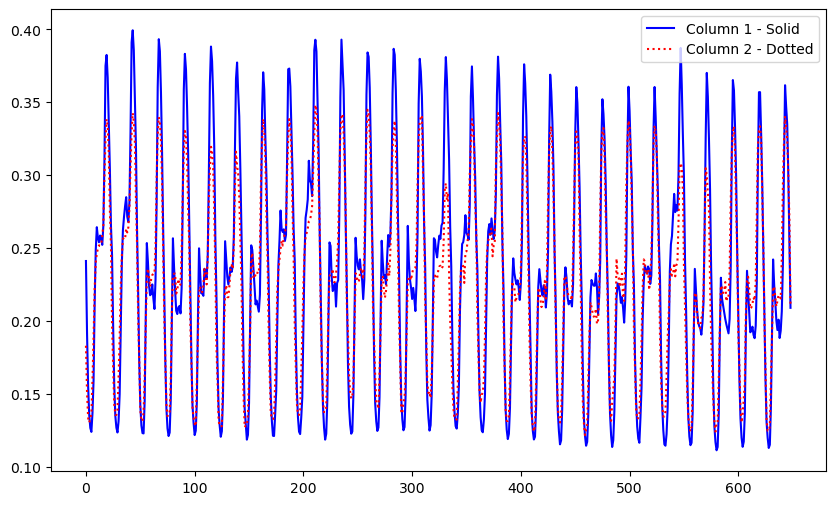

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Plotting the first column with a solid line
plt.plot(compare_df.index, compare_df['kwh'], linestyle='-', color='blue', label='Column 1 - Solid')

# Plotting the second column with a dotted line
plt.plot(compare_df.index, compare_df['Pre kwh'], linestyle=':', color='red', label='Column 2 - Dotted')
plt.legend()
# Show plot
plt.show()

In [39]:
# Delete the SageMaker endpoint and the attached resources
predictor.delete_model()
predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: sagemaker-jumpstart-2024-02-04-20-02-52-210
INFO:sagemaker:Deleting endpoint configuration with name: SmartGrid-lightgbm-regression-model--2024-02-04-20-02-46-934
INFO:sagemaker:Deleting endpoint with name: SmartGrid-lightgbm-regression-model--2024-02-04-20-02-46-934
